## different by splitting to train test valid (here valid and test are switched)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from dataset_loader import *
from utils import *
from datasets import Dataset, DatasetDict
import datasets
import logging
import warnings
from retrain_utils import *
logging.disable(logging.WARNING) 
datasets.set_progress_bar_enabled(False)
warnings.simplefilter("ignore")

SEED = 84
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
dataset_name = 'corona'
ds = get_ds(dataset_name)

In [16]:
test_valid = ds['test'].train_test_split(0.5, seed = 42)
ds = DatasetDict({
    'train': ds['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [17]:
model_name =  'huawei-noah/TinyBERT_General_4L_312D'
folder_name = 'tinybert'

In [5]:
retrain_utils = RetrainUtils(model_name, dataset_name)
added_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.ADD)
removed_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.REMOVE)
replaced_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.REPLACE)

In [7]:
ds['train'] = removed_train

In [8]:
set_seed()
model = load_model(model_name)
tokenized_data = tokenize_dataset(ds, tokenizer_name=model_name, max_length = 64)
_ = train(model, tokenized_data, path=f'{folder_name}/{dataset_name}/check', num_train_epochs=10)
#model.save_pretrained(f'{folder_name}/{dataset_name}/updated_model_v2')

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.409081,0.823755
2,No log,0.412749,0.830460
3,0.428800,0.479932,0.809387
4,0.428800,0.544905,0.822797
5,0.238900,0.561300,0.828544
6,0.238900,0.668619,0.824713
7,0.140000,0.726894,0.825670
8,0.140000,0.814312,0.822797
9,0.085400,0.893269,0.826628
10,0.085400,0.887469,0.827586


### saved best model's folder as 'updated_model_v2'

In [9]:
model = load_model(f'{folder_name}/{dataset_name}/updated_model_v2').to(device).eval()
orig_model = load_model(f'{folder_name}/{dataset_name}/model_v2').to(device).eval()
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [10]:
tokenized_data = tokenize_dataset(ds, tokenizer_name=model_name, max_length = 64)
train(model, tokenized_data, path=f'{folder_name}/{dataset_name}', evaluate = True)['eval_accuracy']

0.8304597701149425

# TinyBert

## Corona

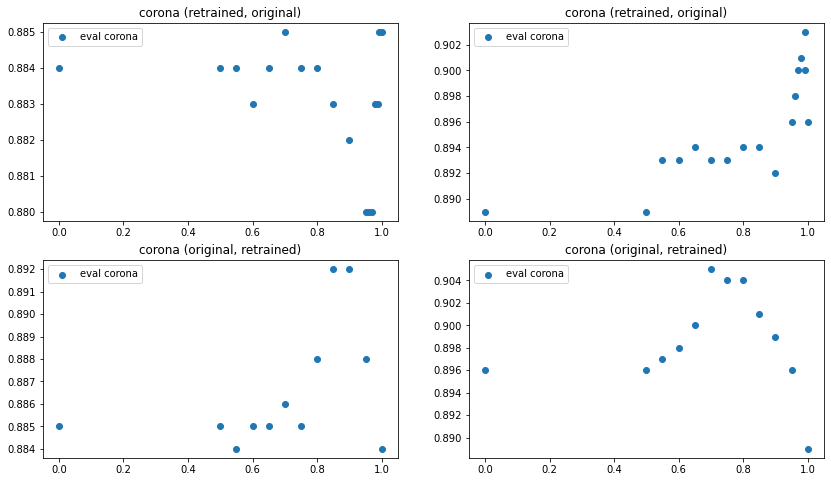

In [13]:
test_valid = get_ds('corona')['test'].train_test_split(0.5, seed = 42)
ensemble_results(folder_name, model_name, 'corona', 'corona', test_valid['test'], test_valid['train'], 'updated_model_v2', 'model_v2')

## Sentiment

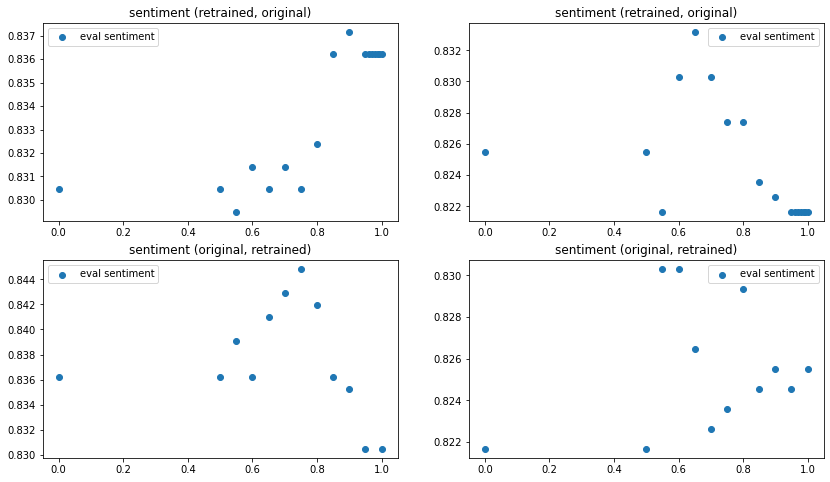

In [13]:
test_valid = get_ds('sentiment')['test'].train_test_split(0.5, seed = 42)
ensemble_results(folder_name, model_name, 'sentiment', 'sentiment', test_valid['test'], test_valid['train'], 'updated_model_v2', 'model_v2')

In [13]:
predict_sentences(model, tokenizer, device, [tokenizer.tokenize("i love movies")])

tensor([[ 1.7911, -1.7094]], device='cuda:0', grad_fn=<AddmmBackward0>)


array([0])

In [14]:
predict_sentences(model, tokenizer, device, [tokenizer.tokenize("i hate movies")])

tensor([[-2.3436,  2.2181]], device='cuda:0', grad_fn=<AddmmBackward0>)


array([1])